# Question 1
## Image Transformations

In [224]:
import cv2
import numpy as np
from src.functions import imread, imshow

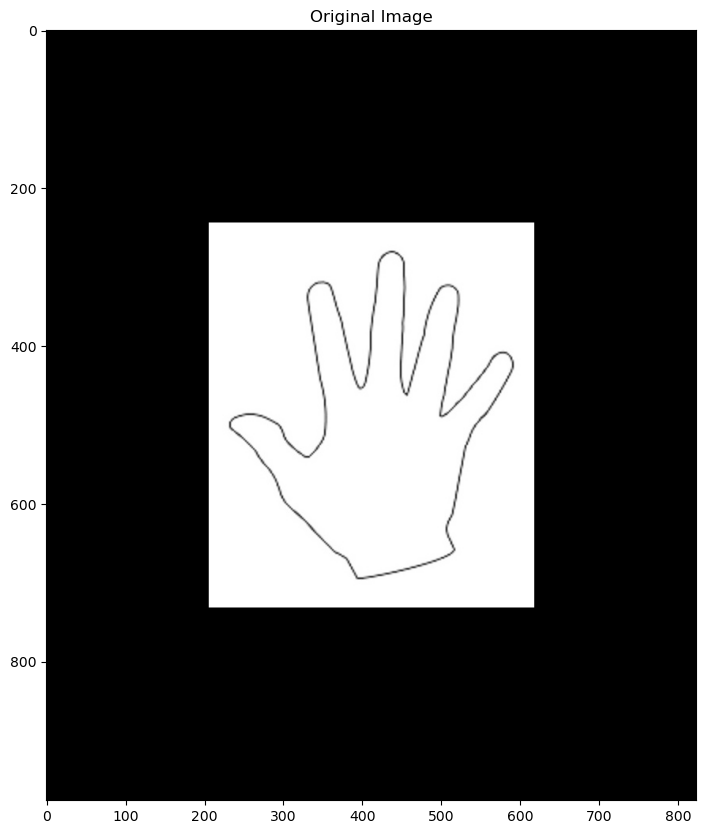

In [225]:
original_image = imread('images/Original_image.jpg')
imshow(original_image , "Original Image")

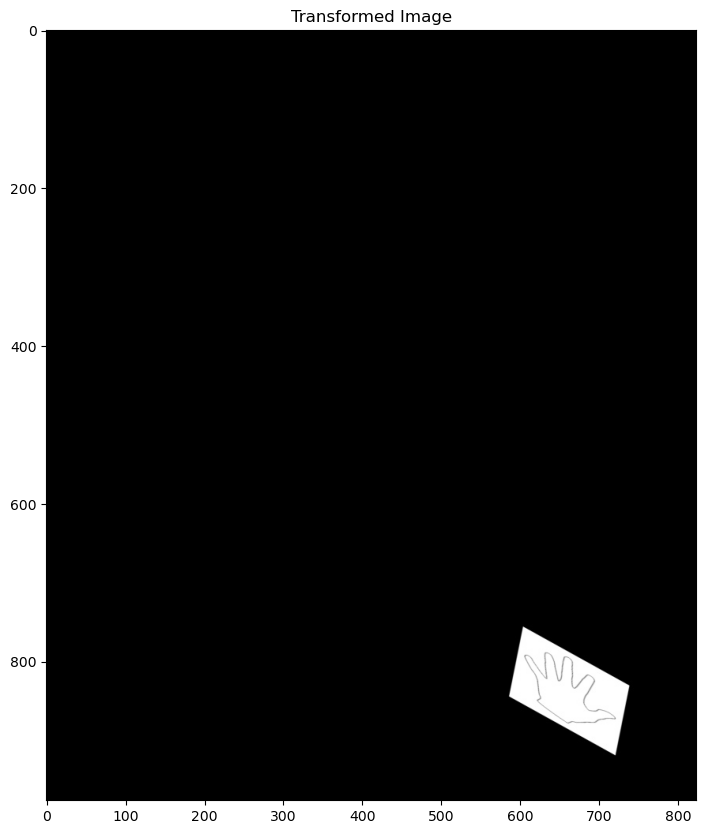

In [226]:
transformed_image = imread('images/transformed_image.jpg')
imshow(transformed_image , "Transformed image")

In [227]:
# TODO: Complete this section

## Moments
Here we will calculate the moments of the original and transformed image.
From the moments we can calculate the centroid of the images. The centroid is the center of mass of the image.
This is vital in order to reverse engineer the transformation and have a reference point to compare the original and transformed image.

In [228]:
# Convert the images to grayscale from RGB
original_image_gray = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
transformed_image_gray = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2GRAY)

In [229]:
# Converting the images to binary
_, original_image_binary = cv2.threshold(original_image_gray, 127, 255, cv2.THRESH_BINARY)
_, transformed_image_binary = cv2.threshold(transformed_image_gray, 127, 255, cv2.THRESH_BINARY)


In [230]:
# Calculate moments of the binary original image
original_moments = cv2.moments(original_image_binary)


# Use the moments to calculate the centroid of original image
original_centroid_x = original_moments['m10'] / original_moments['m00']
original_centroid_y = original_moments['m01'] / original_moments['m00']

original_centroid_x, original_centroid_y

(411.2529058602357, 487.82029149568416)

In [231]:
# Calculate moments of the binary transformed image
transformed_moments = cv2.moments(transformed_image_binary)

# Use the moments to calculate the centroid of transformed image
transformed_centroid_x = transformed_moments['m10'] / transformed_moments['m00']
transformed_centroid_y = transformed_moments['m01'] / transformed_moments['m00']

transformed_centroid_x, transformed_centroid_y

(661.8243284032599, 837.2891638997887)

In [232]:
transformed_image.shape

(976, 824, 3)

In [233]:
heigth, width = original_image.shape[0], original_image.shape[1] # storing height and width of image in defined values

## First Transformation
### Translation

In [234]:
delta_x = original_centroid_x - transformed_centroid_x
delta_y = original_centroid_y - transformed_centroid_y

translation_matrix = np.float32([[1, 0, delta_x], [0, 1, delta_y]])  # going back delta_x pixels in x-axis and delta_y pixels in y-axis
img_detranslate = cv2.warpAffine(transformed_image, translation_matrix, (width, heigth))

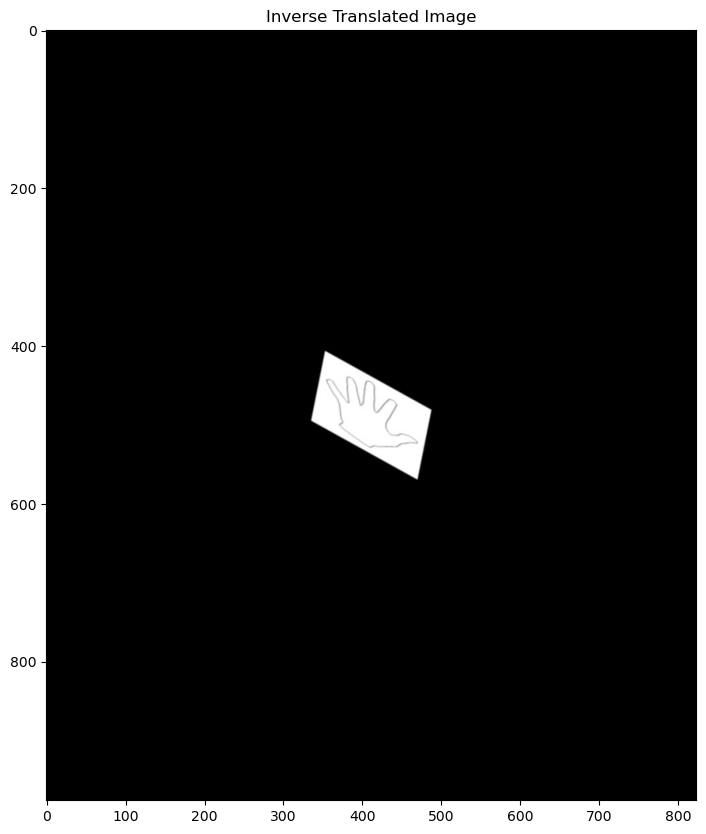

In [235]:
imshow(img_detranslate, "inverse translated image")

## Second Transformation
### Rotation

In [236]:
# Finding the rotation angle by trial and error
img_derotated = cv2.warpAffine(img_detranslate, cv2.getRotationMatrix2D((original_centroid_x, original_centroid_y), 25, 1), (width, heigth))

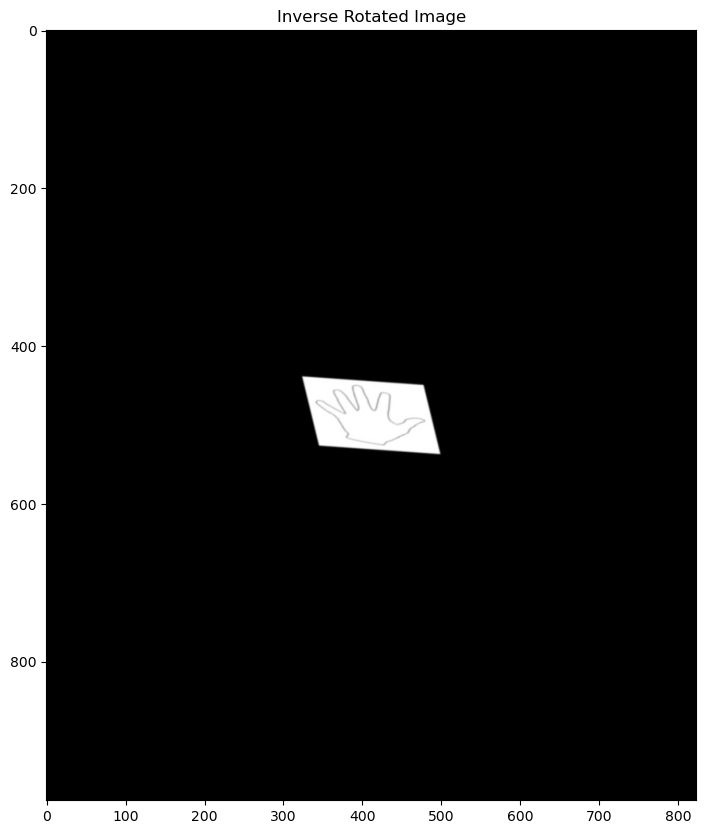

In [237]:
imshow(img_derotated, "inverse rotated image")

## Third Transformation
### Shear

In [238]:
# TODO: Improve from here on

In [239]:
# TODO: find better way to calculate the shear values
sh_x = -0.2
sh_y = 0.001

sheared_img = cv2.warpAffine(img_derotated, np.float32([[1, sh_x, 0], [sh_y, 1, 0]]), (width, heigth))

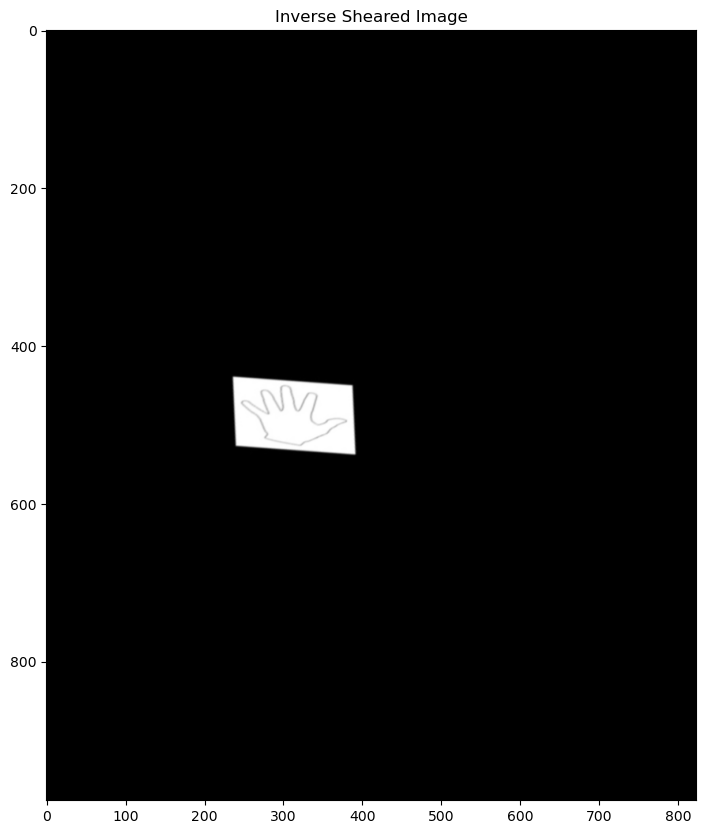

In [240]:
imshow(sheared_img, "inverse sheared image")

## Fourth Transformation
### Scale

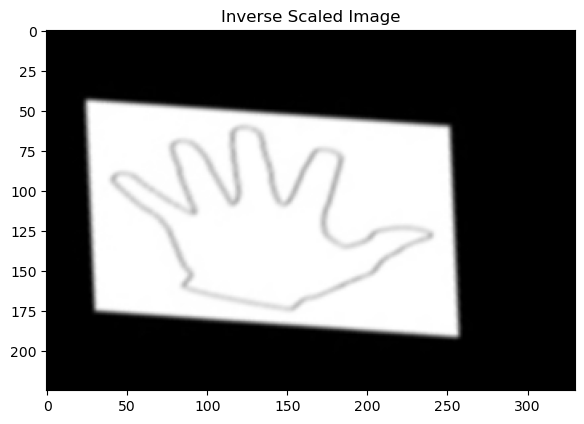

In [241]:
# TODO: find better way to calculate the scale values
img_scaled = cv2.resize(sheared_img[410:560, 220:440], None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)

imshow(img_scaled, "inverse scaled image")

## Fifth Transformation
### Reflection

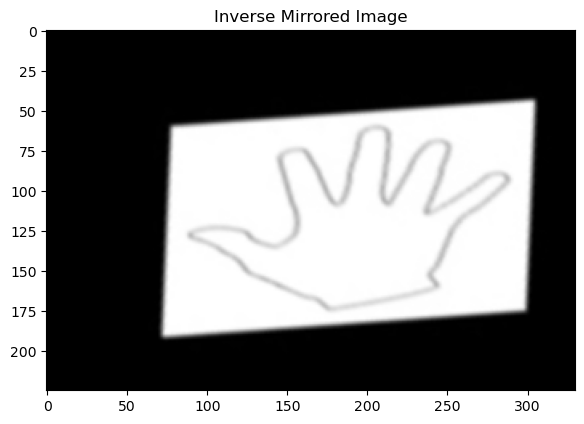

In [242]:
mirror_img = cv2.flip(img_scaled, 1)
imshow(mirror_img, "inverse mirrored image")